In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.interpolate import griddata
import seaborn as sns

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar, get_bg_wind
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

%matplotlib notebook

### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.

__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [45]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [46]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)
x_center = center[:,0]
y_center = center[:,1]


# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values

### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.

In [47]:
var_da = ds_orig.theta_v[0]
#var_da = ds_orig.pres[0]

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)



In [48]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])

In [49]:
# Set level number
i = 50 

center_index = i- (nlev - len(center))-1
lev_index = i-1
lev_height = height[lev_index,0]

# Calculate r and phi for single level
r,phi = cart2pol(lon,lat,center[center_index,])

x_grid = x_center[center_index] + r_grid_da*np.cos(phi_grid_da)
y_grid = y_center[center_index] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [x_center[center_index] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [y_center[center_index] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))


In [50]:
lev_height

3858.5847

In [51]:
values = var_da.values[lev_index]

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

# remap variables for circles with constant radius around center
var_remap = griddata(lonlat_points, values, polar_points, method='cubic')
var_remap = var_remap.reshape((len(r_grid),len(phi_grid)))

# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)

In [52]:
# All modes
fvar = polar_dft(var_polar_da, polar_dim='phi')
fvar_i = polar_idft(fvar, polar_dim='phi')

# Select specific modes

# -4
fvar_neg4 = fvar.copy()
fvar_neg4[0:-4] = 0.
fvar_neg4[-3:] = 0.
fvar_neg4_i = xr.ufuncs.real(polar_idft(fvar_neg4))

# -3
fvar_neg3 = fvar.copy()
fvar_neg3[0:-3] = 0.
fvar_neg3[-2:] = 0.
fvar_neg3_i = xr.ufuncs.real(polar_idft(fvar_neg3))

# -2
fvar_neg2 = fvar.copy()
fvar_neg2[0:-2] = 0.
fvar_neg2[-1] = 0.
fvar_neg2_i = xr.ufuncs.real(polar_idft(fvar_neg2))

# -1
fvar_neg1 = fvar.copy()
fvar_neg1[0:-1] = 0.
fvar_neg1_i = xr.ufuncs.real(polar_idft(fvar_neg1))

# 0
fvar0 = fvar.copy()
fvar0[1:] = 0.
fvar0_i = xr.ufuncs.real(polar_idft(fvar0))

# 1
fvar1 = fvar.copy()
fvar1[0] = 0.
fvar1[2:] = 0.
fvar1_i = xr.ufuncs.real(polar_idft(fvar1))

#2
fvar2 = fvar.copy()
fvar2[0:2] = 0.
fvar2[3:] = 0.
fvar2_i = xr.ufuncs.real(polar_idft(fvar2))

#3
fvar3 = fvar.copy()
fvar3[0:3] = 0.
fvar3[4:] = 0.
fvar3_i = xr.ufuncs.real(polar_idft(fvar3))

#4
fvar4 = fvar.copy()
fvar4[0:4] = 0.
fvar4[5:] = 0.
fvar4_i = xr.ufuncs.real(polar_idft(fvar4))


<IPython.core.display.Javascript object>


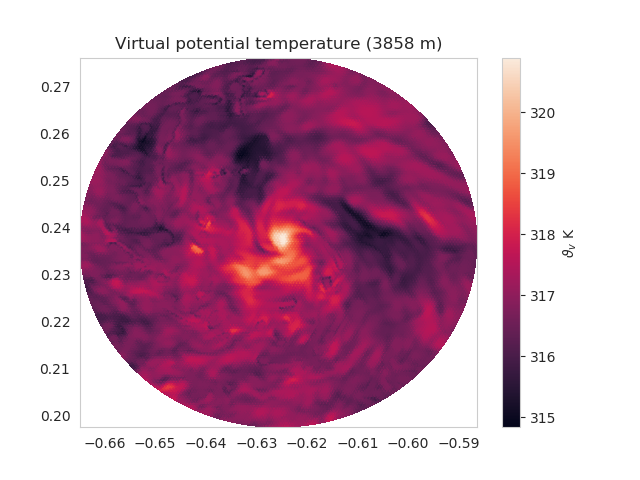

Text(0, 0.5, '$\\vartheta_v$ K')

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_i))
ax.title.set_text('Virtual potential temperature (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel(r'$\vartheta_v$ K')

<IPython.core.display.Javascript object>


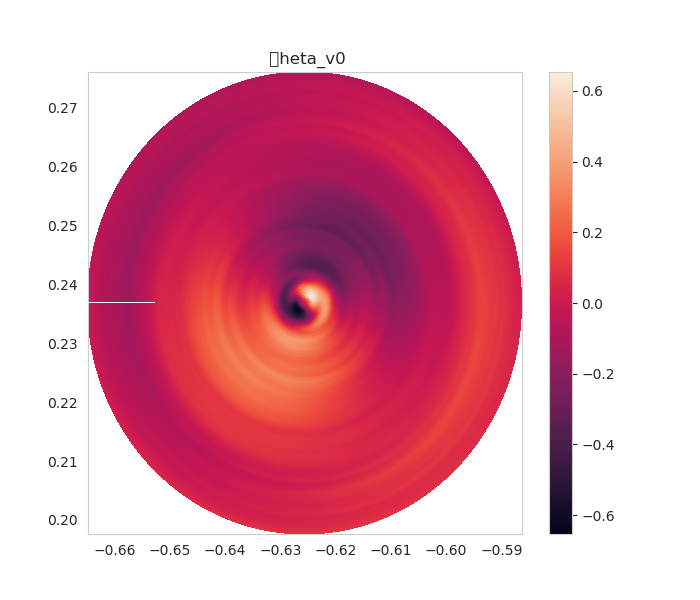

In [54]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
#ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar1_i))
#cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_p4_i))
ax.title.set_text(' \theta_v0')
cbar = plt.colorbar(cs, ax=ax)


In [12]:
fvar_sub = fvar.copy()
fvar_sub[11:-10] = 0.
fvar_sub_i = polar_idft(fvar_sub)

Plot selected fourier modes next to each other.

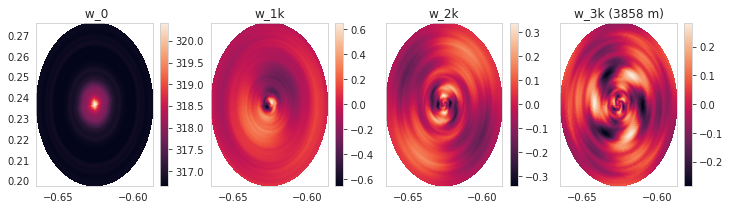

In [35]:
# Colorbar restriction
#vmin = 290; vmax = 320

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(141)
#ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar0_i)) #, vmin=vmin, vmax=vmax)
#cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_p4_i))
ax.title.set_text(' w_0')
cbar = plt.colorbar(cs, ax=ax)


ax = fig.add_subplot(142)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar1_i.x, fvar1_i.y, xr.ufuncs.real(fvar1_i)) #, vmin=vmin, vmax=vmax)
ax.title.set_text('w_1k')
cbar = plt.colorbar(cs, ax=ax)
#cbar.ax.set_ylabel('m s^-1')


ax = fig.add_subplot(143)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar2_i.x, fvar2_i.y, xr.ufuncs.real(fvar2_i)) #, vmin=vmin, vmax=vmax)
ax.title.set_text('w_2k')
cbar = plt.colorbar(cs, ax=ax)



ax = fig.add_subplot(144)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar3_i.x, fvar3_i.y, xr.ufuncs.real(fvar3_i)) #, vmin=vmin, vmax=vmax)
ax.title.set_text('w_3k (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.10, 0.05, 0.7])
#cbar = fig.colorbar(cs, cax=cbar_ax)
#cbar.ax.set_ylabel(r'\theta_v K')

In [31]:
fmodes_max = np.empty(9)

fmodes_max[0] = fvar_neg4_i.max()
fmodes_max[1] = fvar_neg3_i.max()
fmodes_max[2] = fvar_neg2_i.max()
fmodes_max[3] = fvar_neg1_i.max()
fmodes_max[4] = fvar0_i.max()
fmodes_max[5] = fvar1_i.max()
fmodes_max[6] = fvar2_i.max()
fmodes_max[7] = fvar3_i.max()
fmodes_max[8] = fvar4_i.max()


In [16]:
fvar_neg4_i.max()

<xarray.DataArray ()>
array(0.04760967)

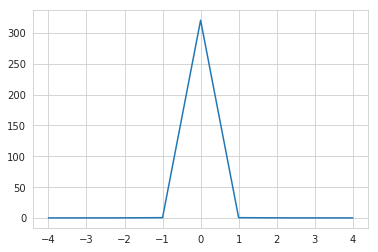

In [32]:
x = [-4,-3, -2, -1 ,0, 1, 2, 3, 4]
plt.plot(x, fmodes_max)

In [16]:
# Calculate maximum value for every mode
fmodes_max = np.empty(len(fvar.k))
fmodes_mean = np.empty(len(fvar.k))
fmodes_min = np.empty(len(fvar.k))

for k in fvar.k.values:
    k = int(k)
    
    fvar_sub = fvar.copy()
    if k == 0:
        fvar_sub[1:] = 0.
    elif k == -1:
        fvar_sub[0:-1]= 0.
    else:
        fvar_sub[0:k] = 0.
        fvar_sub[k+1:] = 0.
    fvar_sub_i = xr.ufuncs.real(polar_idft(fvar_sub))
  
    fmodes_max[k] = fvar_sub_i.max()
    fmodes_min[k] = fvar_sub_i.min()
    fmodes_mean[k] = fvar_sub_i.mean()

Text(0, 0.5, '$\\theta_v$ m  s$^{-1}$')

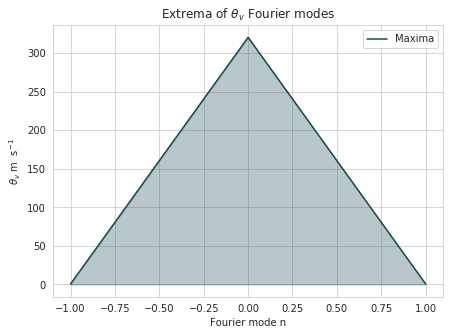

In [30]:
# Plot distribution of max values
sns.set_style("whitegrid")

k_vals = np.concatenate((fvar.k.values[-1:], fvar.k.values[0:2], ))
max_vals = np.concatenate(( fmodes_max[-1:], fmodes_max[0:2]))
min_vals = np.concatenate(( fmodes_min[-1:], fmodes_min[0:2]))

blueish = sns.color_palette("cubehelix", 8)[1]
violetish = sns.color_palette("cubehelix", 8)[5]


fig, ax = plt.subplots(figsize=(7,5))
ax.fill_between(k_vals, 0, max_vals, color=blueish, alpha=.3)
ax.plot(k_vals, max_vals, color=blueish, label="Maxima")
#ax.fill_between(k_vals, 0, min_vals, color=violetish, alpha=.3)
#ax.plot(k_vals, min_vals, color=violetish, label="Minima")

plt.legend()

plt.title(r'Extrema of $\theta_v$ Fourier modes')
plt.xlabel('Fourier mode n')
plt.ylabel(r'$\theta_v$ m  s$^{-1}$')

In [26]:
fmodes_max[-200:]


array([0.00123144, 0.00107736, 0.0010354 , 0.00109398, 0.00115148,
       0.00112907, 0.00098646, 0.00109352, 0.00112235, 0.00108933,
       0.00102497, 0.00108471, 0.0012317 , 0.00137292, 0.00098958,
       0.0011732 , 0.00127653, 0.00142036, 0.00144358, 0.00145373,
       0.00162488, 0.00130311, 0.00171364, 0.00154859, 0.00132209,
       0.00139853, 0.00148975, 0.00165713, 0.00180481, 0.00144897,
       0.00159243, 0.00194468, 0.00166494, 0.00168362, 0.00187475,
       0.00162361, 0.00178101, 0.00186754, 0.00179683, 0.00183227,
       0.00240852, 0.00238436, 0.0022081 , 0.00280994, 0.00300087,
       0.0029109 , 0.00249806, 0.00328517, 0.00333603, 0.00359939,
       0.00204462, 0.00236541, 0.00262933, 0.0031948 , 0.00258019,
       0.00272579, 0.0031125 , 0.00392281, 0.00390178, 0.00293742,
       0.00331226, 0.00437892, 0.00419717, 0.00302894, 0.00316573,
       0.00367855, 0.00390424, 0.00422077, 0.00359716, 0.00352957,
       0.00439366, 0.00450845, 0.00503293, 0.00406742, 0.00458

In [55]:
fvar2 = fvar.copy()
fvar2[0:2] = 0.
fvar2[3:] = 0.
fvar2_i =polar_idft(fvar2, polar_dim='phi')

fvar_something = fvar.copy()
fvar_something [0:2] = 0.
fvar_something [2+1:] = 0.
fvar_something_i = polar_idft(fvar_something, polar_dim='phi')

In [59]:
print(xr.ufuncs.imag(fvar_something).max())
xr.ufuncs.imag(fvar_i).max()

<xarray.DataArray ()>
array(132.11516627)


<xarray.DataArray ()>
array(6.77894328e-16)